# Remake the TIL Code
### P-MNIST Dataset

Import Libraries

In [ ]:
from os.path import isdir
from os import mkdir
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets
from tqdm import tqdm

In [ ]:
device_id = 0
torch.cuda.set_device(device_id)
device = 'cuda:' + str(device_id)
print(device)

cuda:0


In [ ]:
datapath = './datasets'

if not isdir(datapath):
    mkdir(datapath)

mnist_train = datasets.MNIST(datapath, train=True, download=True)
x_train = mnist_train.data
y_train = mnist_train.targets
mnist_test = datasets.MNIST(datapath, train=False, download=True)
x_test = mnist_test.data
y_test = mnist_test.targets

print('train x data before', x_train.size())
print('test x data before', x_test.size())

x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

print('\ntrain x data after', x_train.size())
print('test x data after', x_test.size())

print('\ntrain y', y_train.size())
print('test y', y_test.size())

100%|██████████| 9912422/9912422 [00:00<00:00, 42838592.96it/s]


Extracting ./datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 98967070.12it/s]

Extracting ./datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 11911669.34it/s]


Extracting ./datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20617455.38it/s]

Extracting ./datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



train x data before torch.Size([60000, 28, 28])
test x data before torch.Size([10000, 28, 28])

train x data after torch.Size([60000, 784])
test x data after torch.Size([10000, 784])

train y torch.Size([60000])
test y torch.Size([10000])


In [ ]:

# allows the randomization to go through different seeds
num_task = 20
step = 100
init = 100
seeds = np.arange(init, num_task*step + init, step)

# finds how many classes there are and makes an empty train_y
n_class = len(np.unique(y_train))

# changes each number from the labels in y_train
# into 1's for the column in train_y that corresponds with the label
# this allows train_y to have the labels encoded into 0's and 1's only
train_y = np.zeros((len(y_train), n_class))
for i in range(train_y.shape[0]):
    train_y[i, y_train[i]] = 1

# same thing done on test_y
test_y = np.zeros((len(y_test), n_class))
for i in range(test_y.shape[0]):
    test_y[i, y_test[i]] = 1

# Check shape of train and test y
print('empty train y', train_y.shape)
print('empty test y', test_y.shape)

data = [[x_train, train_y]]
data_test = [[x_test, test_y]]

pixels = np.arange(x_train.shape[1])
pixel_set = [pixels]

for task in range(num_task - 1):
    np.random.seed(seeds[task])
    np.random.shuffle(pixels)
    pixel_set.append(pixels)

    x = x_train[:, pixels]
    data.append([x, train_y])

    x = x_test[:, pixels]
    data_test.append([x, test_y])

X_train, X_test = [], []
Y_train, Y_test = [], []

for task in range(num_task):
    X_currTask_train = data[task][0].numpy()
    Y_currTask_train = data[task][1]
    X_currTask_test = data_test[task][0].numpy()
    Y_currTask_test = data_test[task][1]

    X_train.append(X_currTask_train)
    X_test.append(X_currTask_test)
    Y_train.append(Y_currTask_train)
    Y_test.append(Y_currTask_test)

X_train = np.asarray(X_train)
X_train = np.reshape(X_train, (num_task, X_train.shape[1], X_train.shape[2]))
X_test = np.asarray(X_test)
X_test = np.reshape(X_test, (num_task, X_test.shape[1], X_test.shape[2]))
Y_train = np.asarray(Y_train)
Y_train = np.reshape(Y_train, (num_task, Y_train.shape[1], Y_train.shape[2]))
Y_test = np.asarray(Y_test)
Y_test = np.reshape(Y_test, (num_task, Y_test.shape[1], Y_test.shape[2]))

print('train X', X_train.shape)
print('test X', X_test.shape)
print('train Y', Y_train.shape)
print('test Y', Y_test.shape)

empty train y (60000, 10)
empty test y (10000, 10)
train X (20, 60000, 784)
test X (20, 10000, 784)
train Y (20, 60000, 10)
test Y (20, 10000, 10)


In [ ]:
num_task = 20
n_class = 10

r1 = 11
r2 = 1

batch_size = 128
train_epochs = [500,500,500,500,500,500,500,500,500,500,500,500,500,500,500,
                500,500,500,500,500]
                
lr_base = 1e-5
lr_cont = 1e-4

In [ ]:
relu = torch.nn.ReLU()

softmax = torch.nn.Softmax(dim=1)
mse_loss = torch.nn.MSELoss(reduction='mean')
w_task = []

for task in range(num_task):
    if task == 0:
        r = r1
        lr = lr_base
    else:
        r = r2
        lr = lr_cont

    wR1 = torch.empty(x_train.shape[1], r).to(device)
    wL1 = torch.empty(256, r).to(device)
    s1 = torch.ones(r).to(device)
    b1 = torch.zeros(256).to(device)

    wR2 = torch.empty(256, r).to(device)
    wL2 = torch.empty(256, r).to(device)
    s2 = torch.ones(r).to(device)
    b2 = torch.zeros(256).to(device)

    w3 = torch.empty(256, n_class).to(device)
    b3 = torch.zeros(n_class).to(device)

    torch.nn.init.orthogonal_(wR1)
    torch.nn.init.orthogonal_(wL1)
    torch.nn.init.orthogonal_(wR2)
    torch.nn.init.orthogonal_(wL2)
    torch.nn.init.orthogonal_(w3)

    w_task.append([wR1, wL1, wR2, wL2, w3, s1, s2, b1, b2, b3])

Task Progress:


  0%|          | 0/20 [00:00<?, ?it/s]

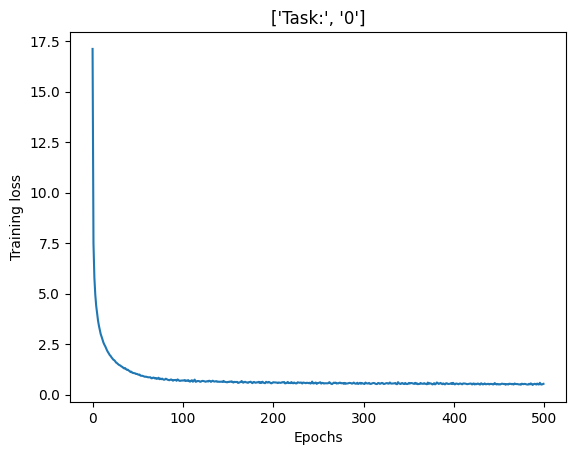

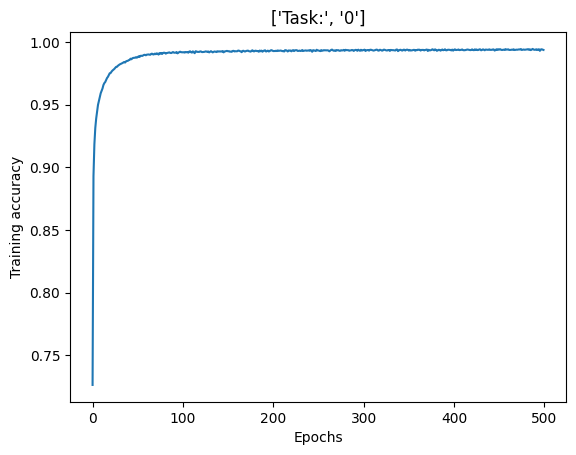

  5%|▌         | 1/20 [09:49<3:06:42, 589.63s/it]

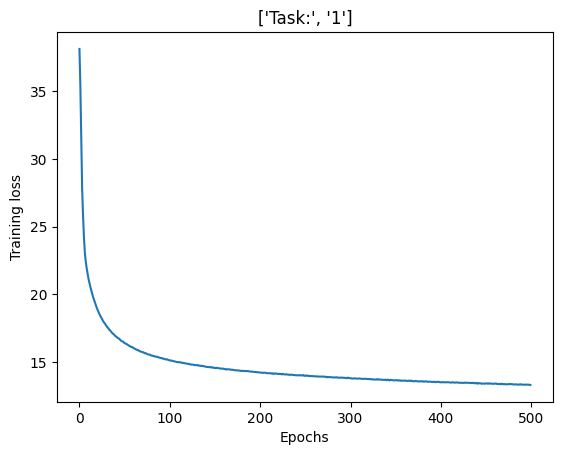

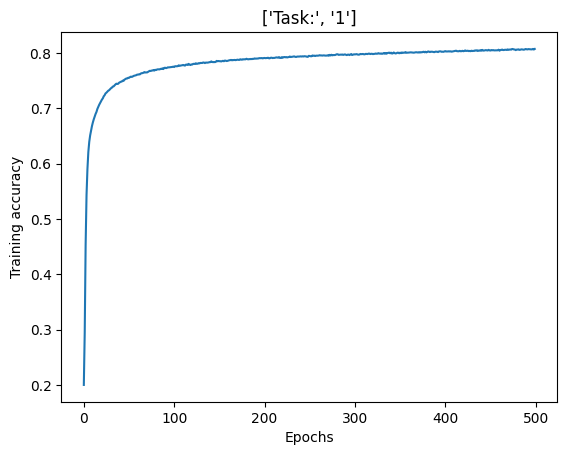

 10%|█         | 2/20 [20:28<3:05:36, 618.71s/it]

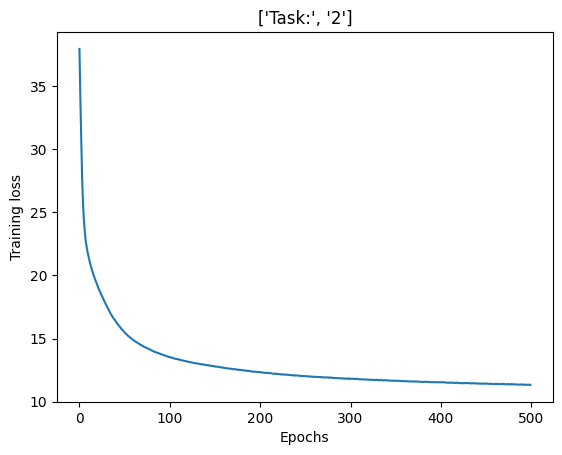

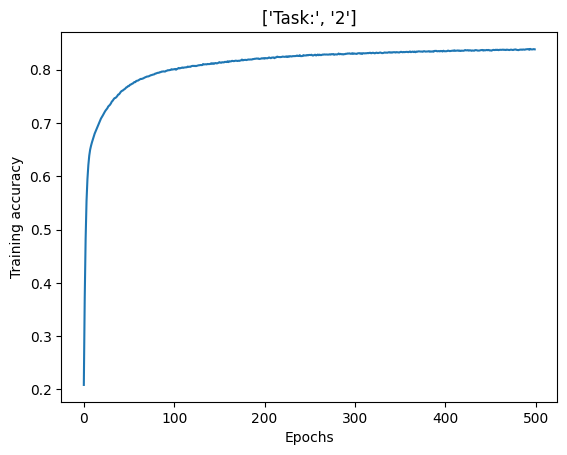

 15%|█▌        | 3/20 [31:06<2:57:48, 627.55s/it]

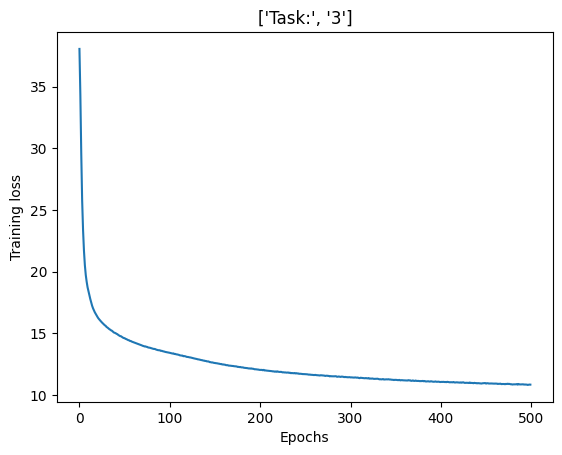

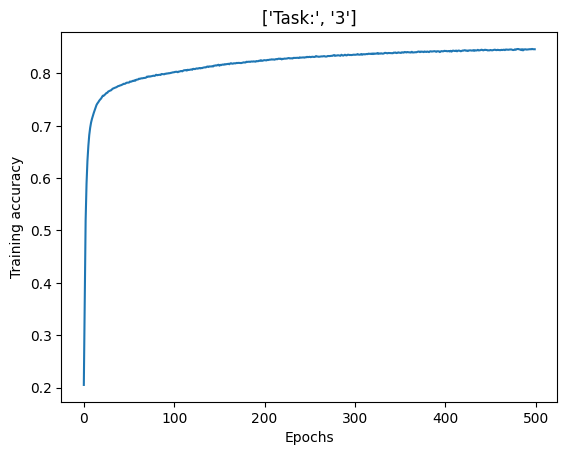

 20%|██        | 4/20 [41:41<2:48:08, 630.50s/it]

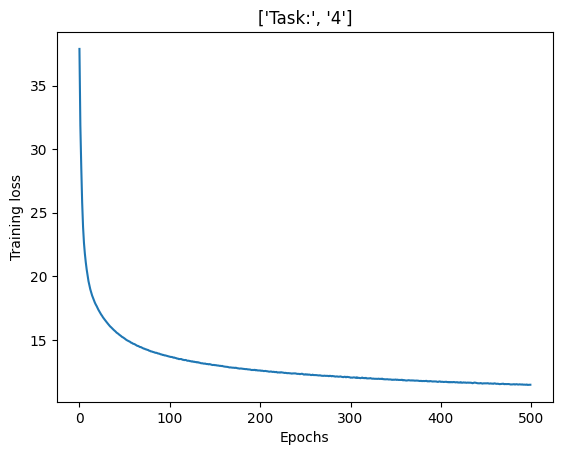

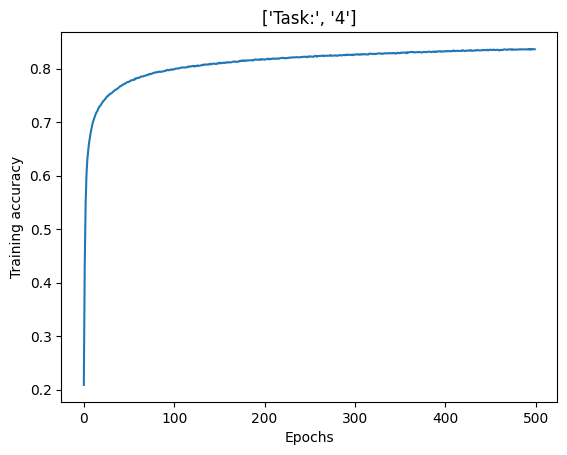

 25%|██▌       | 5/20 [52:28<2:39:07, 636.52s/it]

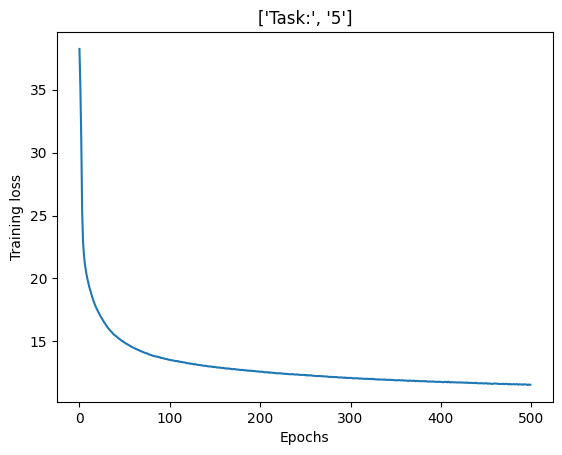

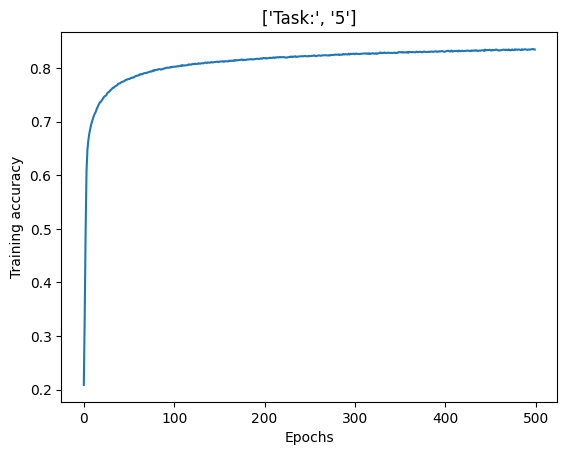

 30%|███       | 6/20 [1:03:19<2:29:37, 641.23s/it]

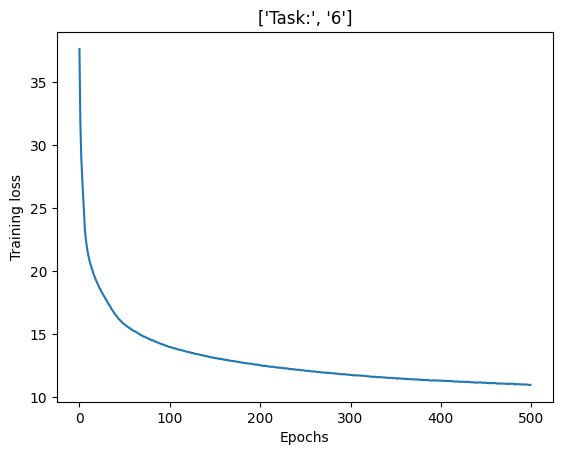

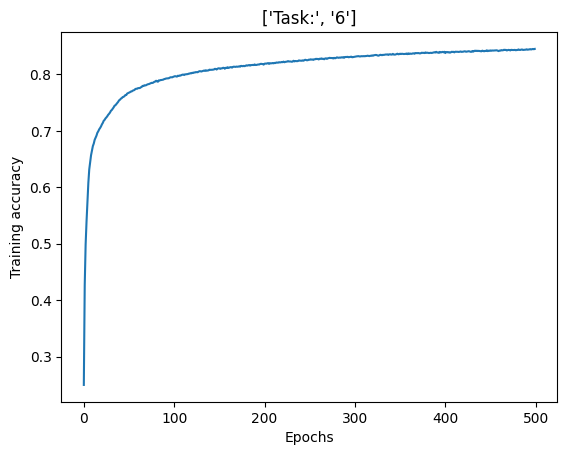

 35%|███▌      | 7/20 [1:14:00<2:18:54, 641.08s/it]

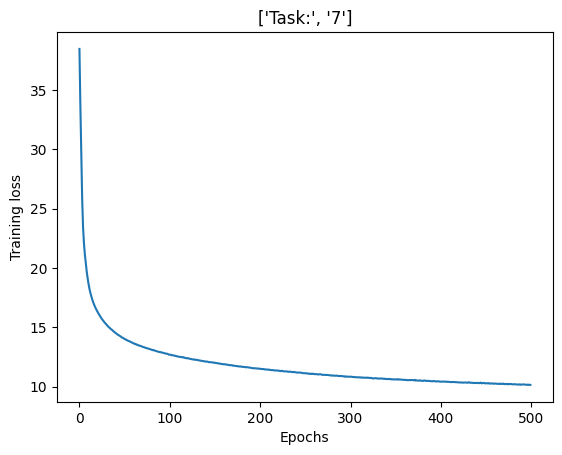

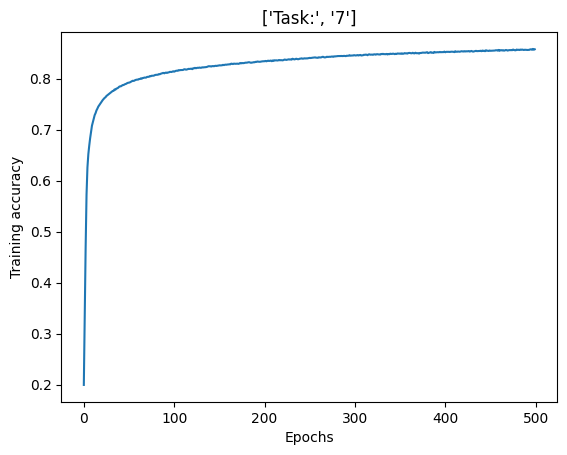

 40%|████      | 8/20 [1:24:40<2:08:08, 640.72s/it]

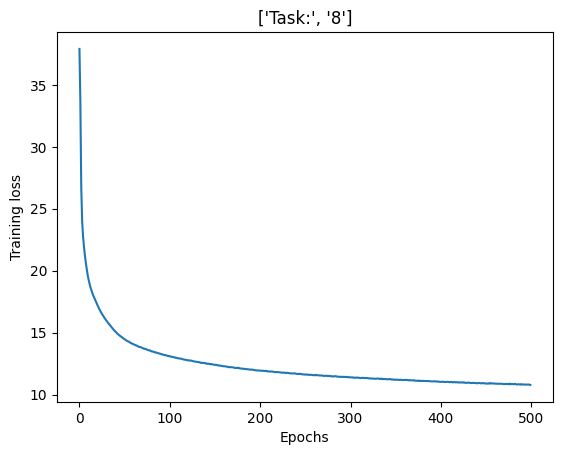

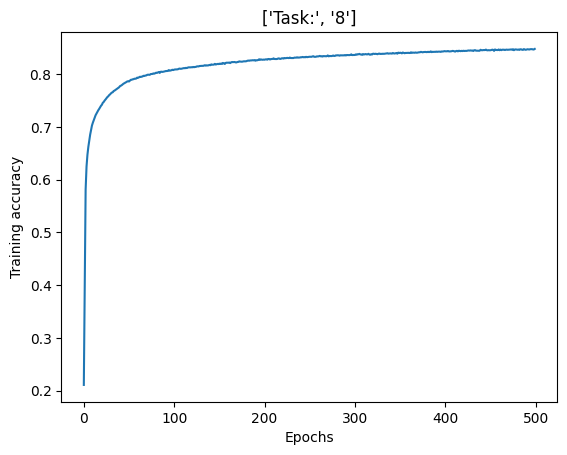

 45%|████▌     | 9/20 [1:35:17<1:57:16, 639.66s/it]

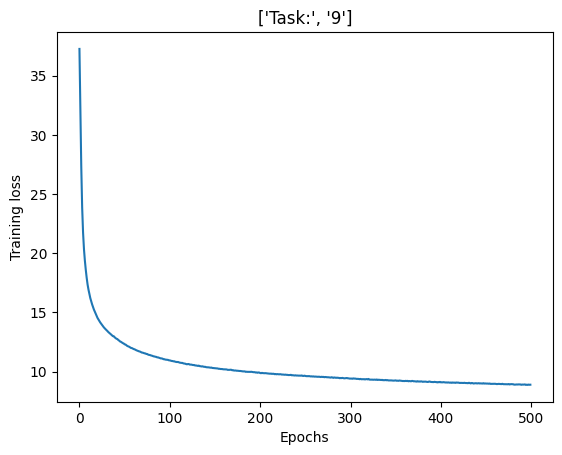

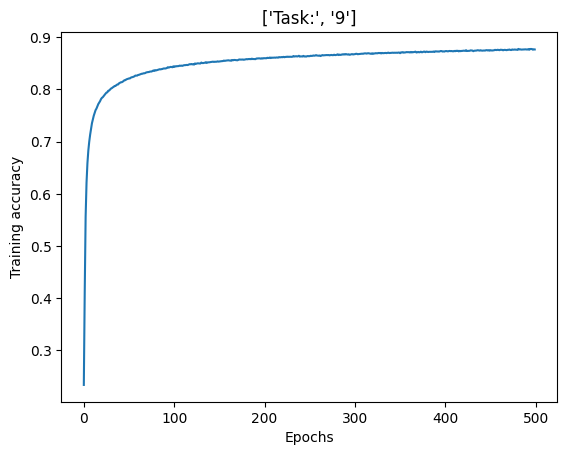

 50%|█████     | 10/20 [1:45:50<1:46:15, 637.53s/it]

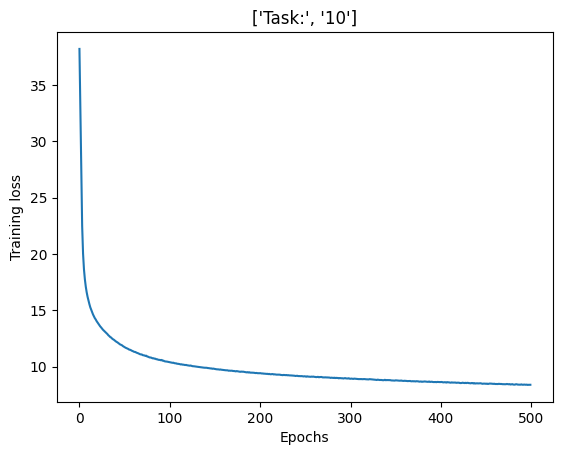

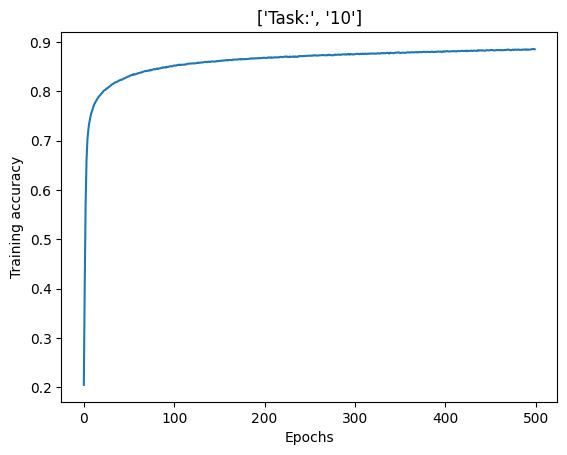

 55%|█████▌    | 11/20 [1:56:16<1:35:07, 634.15s/it]

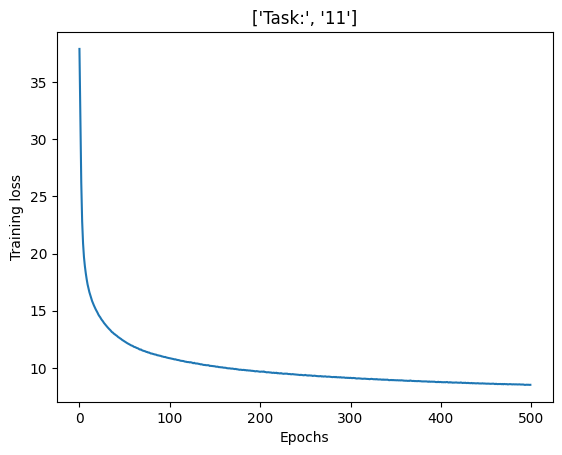

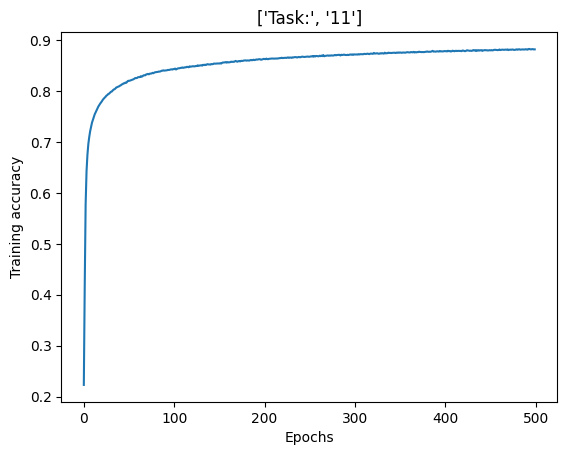

 60%|██████    | 12/20 [2:06:53<1:24:40, 635.02s/it]

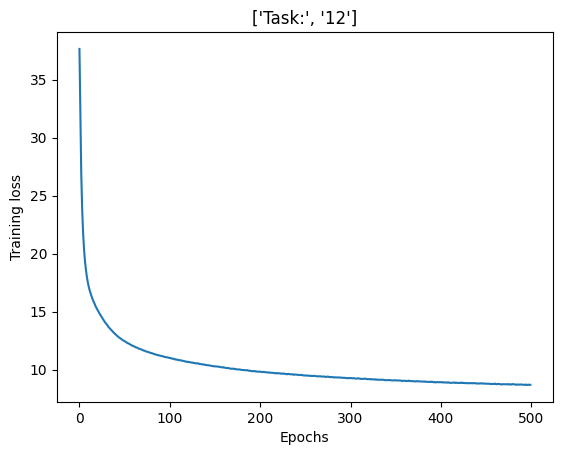

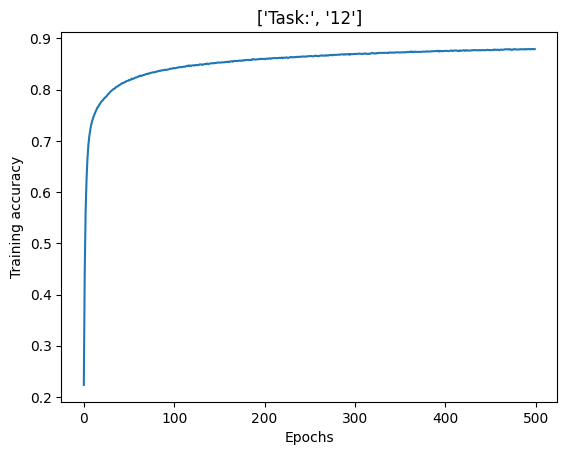

 65%|██████▌   | 13/20 [2:17:29<1:14:05, 635.14s/it]

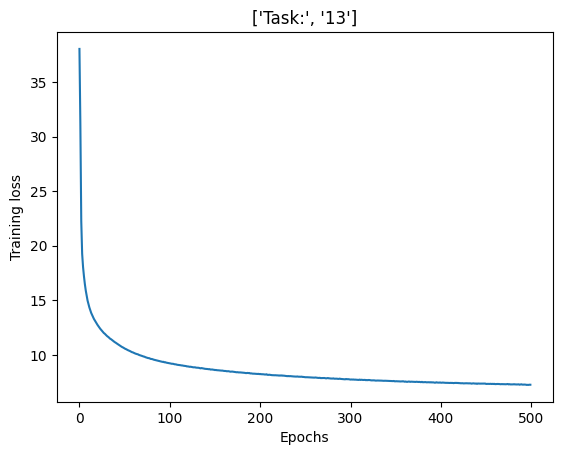

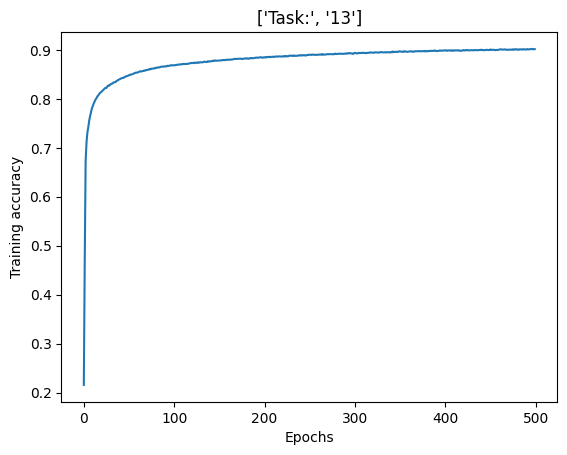

 70%|███████   | 14/20 [2:28:06<1:03:35, 635.84s/it]

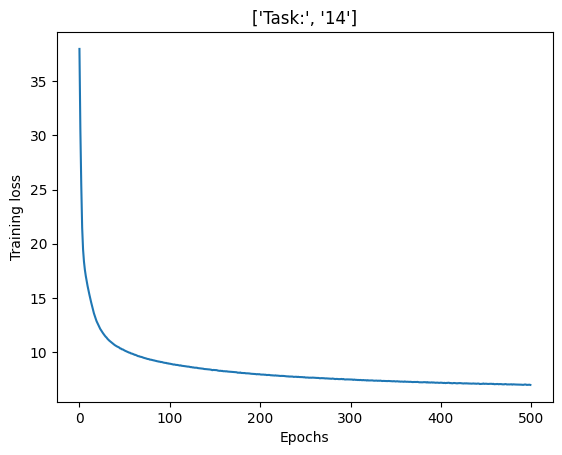

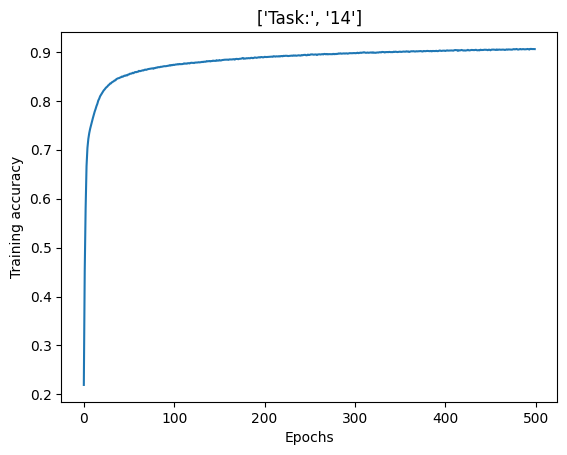

 75%|███████▌  | 15/20 [2:38:40<52:56, 635.36s/it]  

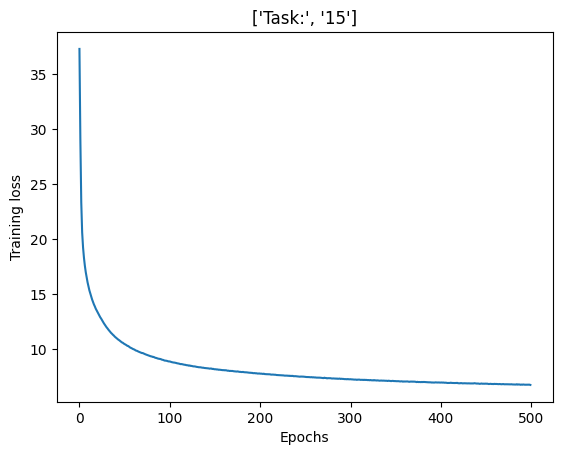

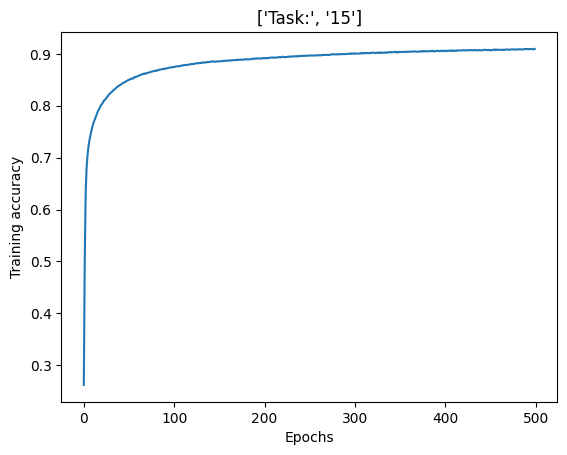

 80%|████████  | 16/20 [2:49:07<42:11, 632.85s/it]

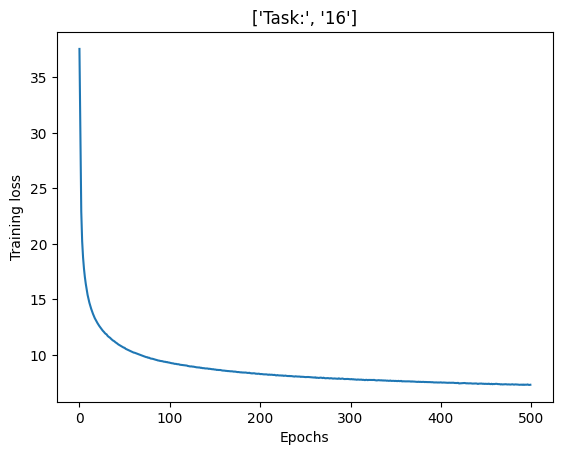

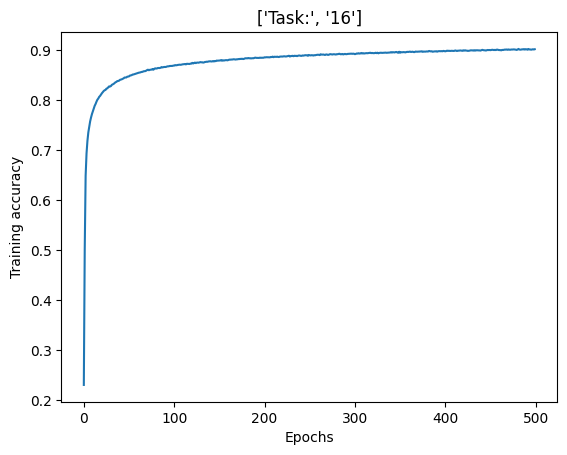

 85%|████████▌ | 17/20 [2:59:17<31:17, 625.98s/it]

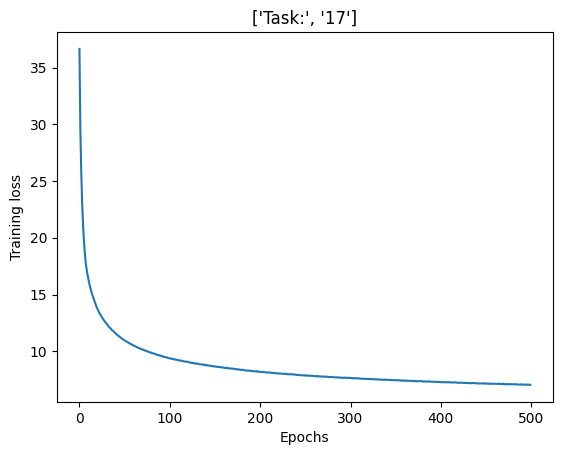

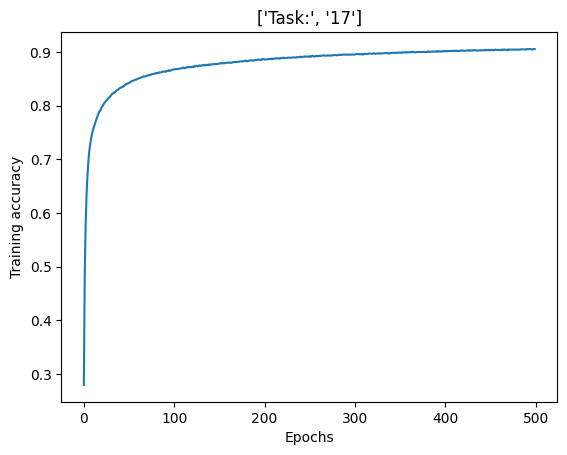

 90%|█████████ | 18/20 [3:09:27<20:41, 620.94s/it]

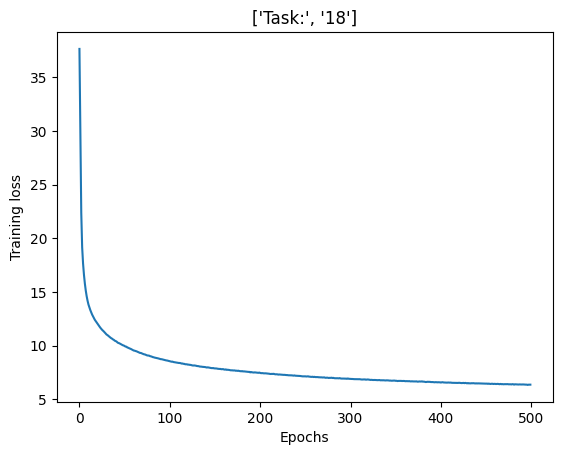

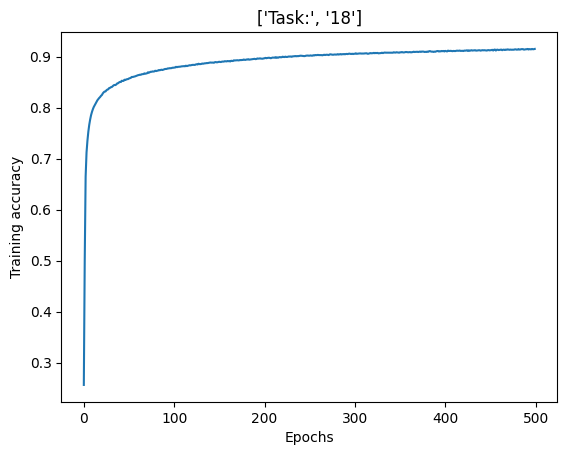

 95%|█████████▌| 19/20 [3:19:34<10:17, 617.03s/it]

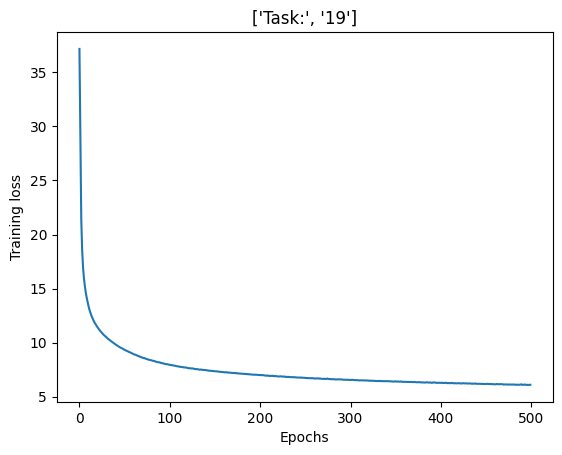

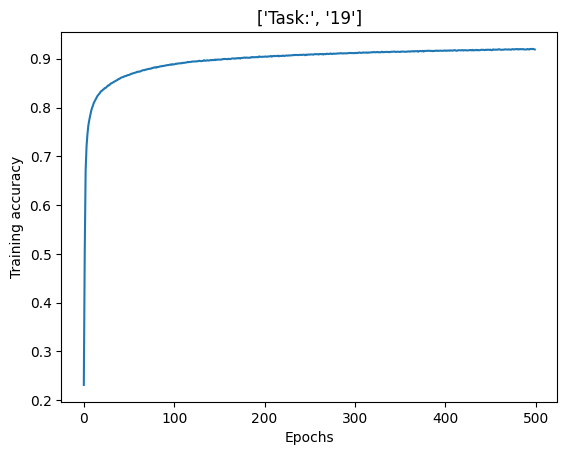

100%|██████████| 20/20 [3:29:50<00:00, 629.51s/it]


In [ ]:
print("Task Progress:")

# Training
U_, S_, V_ = [], [], []
U_.append(w_task[0][0])
U_.append(w_task[0][2])
S_.append(w_task[0][5])
S_.append(w_task[0][6])
V_.append(w_task[0][1])
V_.append(w_task[0][3])

S1_tasks = []
S2_tasks = []
b_tasks = []
w3_tasks = []

for task in tqdm(range(num_task)):
    dwR1 = torch.autograd.Variable(w_task[task][0], requires_grad=True)
    dwL1 = torch.autograd.Variable(w_task[task][1], requires_grad=True)
    dwR2 = torch.autograd.Variable(w_task[task][2], requires_grad=True)
    dwL2 = torch.autograd.Variable(w_task[task][3], requires_grad=True)
    w3 = torch.autograd.Variable(w_task[task][4], requires_grad=True)

    # Selector
    if task == 0:
        ds1 = torch.autograd.Variable(w_task[task][5], requires_grad=True)
        ds2 = torch.autograd.Variable(w_task[task][6], requires_grad=True)
    else:
        ds1 = torch.cat((torch.zeros(S1_tasks[task-1].shape).to(device), w_task[task][5]), dim=0)
        ds2 = torch.cat((torch.zeros(S2_tasks[task-1].shape).to(device), w_task[task][6]), dim=0)
        ds1 = torch.autograd.Variable(ds1, requires_grad=True)
        ds2 = torch.autograd.Variable(ds2, requires_grad=True)
    
    # Bias
    b1 = torch.autograd.Variable(w_task[task][7], requires_grad=True)
    b2 = torch.autograd.Variable(w_task[task][8], requires_grad=True)
    b3 = torch.autograd.Variable(w_task[task][9], requires_grad=True)

    optimizer = torch.optim.Adam([dwR1, dwL1, dwR2, dwL2, w3, ds1, ds2, b1, b2, b3], lr = lr)

    loss_epoch = []
    epoch_correct, epoch_total = 0, 0
    epoch_accuracy = []
    times = 1

    for epoch in range(train_epochs[task]):
        train_size = len(X_train[task])
        batch_no = np.int16(np.ceil(train_size/np.float64(batch_size)))

        epoch_idx = np.arange(train_size)
        np.random.shuffle(epoch_idx)

        loss_batch = 0

        for batch_idx in range(0, batch_no):
            x_batch = X_train[task][epoch_idx[batch_idx*batch_size:np.min([(batch_idx+1)*batch_size, train_size])], :]
            y_batch = Y_train[task][epoch_idx[batch_idx*batch_size:np.min([(batch_idx+1)*batch_size, train_size])]]

            x_batch_tensor = torch.FloatTensor(x_batch).to(device)
            y_batch_tensor = torch.FloatTensor(y_batch).to(device)

            if task == 0:
                w1 = torch.matmul(torch.matmul(dwR1, torch.diag(ds1)), dwL1.T)
                w2 = torch.matmul(torch.matmul(dwR2, torch.diag(ds2)), dwL2.T)
            else:
                U_inc1 = torch.cat((U_[0].to(device), dwR1), dim=1)
                V_inc1 = torch.cat((V_[0].to(device), dwL1), dim=1)
                w1 = torch.matmul(torch.matmul(U_inc1, torch.diag(ds1)), V_inc1.T)

                U_inc2 = torch.cat((U_[1].to(device), dwR2), dim=1)
                V_inc2 = torch.cat((V_[1].to(device), dwL2), dim=1)
                w2 = torch.matmul(torch.matmul(U_inc2, torch.diag(ds2)), V_inc2.T)

            h1 = relu(torch.matmul(x_batch_tensor, w1) + b1)
            h2 = relu(torch.matmul(h1, w2) + b2)

            y_hat = softmax(torch.matmul(h2, w3) + b3)
            loss = mse_loss(y_hat, y_batch_tensor)
            loss_batch = loss_batch + loss.item()

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()

            # Prediction
            prediction = np.argmax(y_hat.cpu().detach().numpy(), axis=1)
            y_label = np.argmax(y_batch_tensor.cpu().detach().numpy(), axis=1)
            epoch_correct += int(sum(y_label == prediction))
            epoch_total += int(len(y_label))

        epoch_accuracy.append(float(epoch_correct / epoch_total))
        epoch_correct, epoch_total = 0, 0

        loss_epoch.append(loss_batch)

    # Concatenate the wieght matrix of every tasks
    with torch.no_grad():
        if task == 0:
            U_[0] = dwR1.detach()
            U_[1] = dwR2.detach()
            S_[0] = ds1.detach()
            S_[1] = ds2.detach()
            V_[0] = dwL1.detach()
            V_[1] = dwL2.detach()
        elif task >= 1:
            U_[0] = torch.cat((U_[0], dwR1.detach()), dim=1)
            U_[1] = torch.cat((U_[1], dwR2.detach()), dim=1)
            S_[0] = ds1
            S_[1] = ds2
            V_[0] = torch.cat((V_[0], dwL1.detach()), dim=1)
            V_[1] = torch.cat((V_[1], dwL2.detach()), dim=1)

        # Save selector matrices of every task
        S1_tasks.append(ds1)
        S2_tasks.append(ds2)
        b_tasks.append([b1.detach(), b2.detach(), b3.detach()])
        w3_tasks.append(w3.detach())

    # Plot loss
    plt.figure()
    plt.plot(loss_epoch)
    plt.title(['Task:', str(task)])
    plt.xlabel('Epochs')
    plt.ylabel('Training loss')
    plt.show()

    # Plot epoch accuracy
    plt.figure()
    plt.plot(epoch_accuracy)
    plt.title(['Task:', str(task)])
    plt.xlabel('Epochs')
    plt.ylabel('Training accuracy')
    plt.show()

    with torch.no_grad():
        w_task[task][0] = dwR1.detach()
        w_task[task][1] = dwL1.detach()
        w_task[task][2] = dwR2.detach()
        w_task[task][3] = dwL2.detach()
        w_task[task][4] = w3.detach()
        w_task[task][5] = ds1.detach()
        w_task[task][6] = ds2.detach()
        w_task[task][7] = b1.detach()
        w_task[task][8] = b2.detach()
        w_task[task][9] = b3.detach()

final_weights = [U_, V_, S1_tasks, S2_tasks, b_tasks, w3_tasks]
                      

In [ ]:
test_accuracy = []
for task in range(num_task):
    test_correct, test_total = 0, 0
    with torch.no_grad():
        test_size = len(X_test[task])
        batch_no = np.int16(np.ceil(test_size/np.float64(batch_size)))
        epoch_idx = np.arange(test_size)
        np.random.shuffle(epoch_idx)

        for batch_idx in range(0, batch_no):
            x_batch = X_test[task][epoch_idx[batch_idx*batch_size:np.min([(batch_idx+1)*batch_size, test_size])],  :]
            y_batch = Y_test[task][epoch_idx[batch_idx*batch_size:np.min([(batch_idx+1)*batch_size, test_size])]]

            x_batch_tensor = torch.FloatTensor(x_batch).to(device)
            y_batch_tensor = torch.FloatTensor(y_batch).to(device)

            u_1 = U_[0][:, 0:r1+(task)*r2]
            s_1 = S1_tasks[task]
            v_1 = V_[0][:, 0:r1+(task)*r2]
            u_2 = U_[1][:, 0:r1+(task)*r2]
            s_2 = S2_tasks[task]
            v_2 = V_[1][:, 0:r1+(task)*r2]

            w1 = torch.matmul(torch.matmul(u_1, torch.diag(s_1)), v_1.T)
            w2 = torch.matmul(torch.matmul(u_2, torch.diag(s_2)), v_2.T)

            h1 = relu(torch.matmul(x_batch_tensor, w1) + b_tasks[task][0])
            h2 = relu(torch.matmul(h1, w2) + b_tasks[task][1])

            # Prediction
            w3 = w3_tasks[task]
            y_hat = softmax(torch.matmul(h2, w3) + b_tasks[task][2])
            prediction = np.argmax(y_hat.cpu().detach().numpy(), axis=1)
            y_label = np.argmax(y_batch_tensor.cpu().detach().numpy(), axis=1)
            test_correct += int(sum(y_label == prediction))
            test_total += int(len(y_label))

        test_accuracy.append(float(test_correct / test_total))

    print("Test Accuracy: ", test_accuracy, "Avg: ", np.mean(test_accuracy))

Test Accuracy:  [0.9624] Avg:  0.9624
Test Accuracy:  [0.9624, 0.7848] Avg:  0.8736
Test Accuracy:  [0.9624, 0.7848, 0.8076] Avg:  0.8516
Test Accuracy:  [0.9624, 0.7848, 0.8076, 0.8201] Avg:  0.8437250000000001
Test Accuracy:  [0.9624, 0.7848, 0.8076, 0.8201, 0.8175] Avg:  0.83848
Test Accuracy:  [0.9624, 0.7848, 0.8076, 0.8201, 0.8175, 0.8114] Avg:  0.8339666666666666
Test Accuracy:  [0.9624, 0.7848, 0.8076, 0.8201, 0.8175, 0.8114, 0.8189] Avg:  0.8318142857142857
Test Accuracy:  [0.9624, 0.7848, 0.8076, 0.8201, 0.8175, 0.8114, 0.8189, 0.8255] Avg:  0.831025
Test Accuracy:  [0.9624, 0.7848, 0.8076, 0.8201, 0.8175, 0.8114, 0.8189, 0.8255, 0.8238] Avg:  0.8302222222222223
Test Accuracy:  [0.9624, 0.7848, 0.8076, 0.8201, 0.8175, 0.8114, 0.8189, 0.8255, 0.8238, 0.8512] Avg:  0.83232
Test Accuracy:  [0.9624, 0.7848, 0.8076, 0.8201, 0.8175, 0.8114, 0.8189, 0.8255, 0.8238, 0.8512, 0.8614] Avg:  0.8349636363636364
Test Accuracy:  [0.9624, 0.7848, 0.8076, 0.8201, 0.8175, 0.8114, 0.8189, 0.825

In [ ]:
train_accuracy = []
for task in range(num_task):
    train_correct, train_total = 0, 0
    with torch.no_grad():
        train_size = len(X_train[task])
        batch_no = np.int16(np.ceil(train_size/np.float64(batch_size)))
        epoch_idx = np.arange(train_size)
        np.random.shuffle(epoch_idx)

        for batch_idx in range(0, batch_no):
            x_batch = X_train[task][epoch_idx[batch_idx*batch_size:np.min([(batch_idx+1)*batch_size, train_size])], :]
            y_batch = Y_train[task][epoch_idx[batch_idx*batch_size:np.min([(batch_idx+1)*batch_size, train_size])]]

            x_batch_tensor = torch.FloatTensor(x_batch).to(device)
            y_batch_tensor = torch.FloatTensor(y_batch).to(device)

            u_1 = U_[0][:, 0:r1+(task)*r2]
            s_1 = S1_tasks[task]
            v_1 = V_[0][:, 0:r1+(task)*r2]
            u_2 = U_[1][:,0:r1+(task)*r2]
            s_2 = S2_tasks[task]
            v_2 = V_[1][:,0:r1+(task)*r2]

            w1 = torch.matmul(torch.matmul(u_1, torch.diag(s_1)), v_1.T)
            w2 = torch.matmul(torch.matmul(u_2, torch.diag(s_2)), v_2.T)

            h1 = relu(torch.matmul(x_batch_tensor, w1) + b_tasks[task][0])
            h2 = relu(torch.matmul(h1, w2) + b_tasks[task][1])

            # Prediction
            w3 = w3_tasks[task]
            y_hat = softmax(torch.matmul(h2, w3) + b_tasks[task][2])

            prediction = np.argmax(y_hat.cpu().detach().numpy(), axis=1)
            y_label = np.argmax(y_batch_tensor.cpu().detach().numpy(), axis=1)
            train_correct += int(sum(y_label == prediction))
            train_total += int(len(y_label))

    train_accuracy.append(float(train_correct / train_total))
print("Training Accuracy: ", train_accuracy, "Avg: ", np.mean(train_accuracy))

Training Accuracy:  [0.9944833333333334, 0.8062, 0.8400666666666666, 0.8474666666666667, 0.8369166666666666, 0.8363166666666667, 0.8455166666666667, 0.8581166666666666, 0.84945, 0.8768666666666667, 0.8871166666666667, 0.8823833333333333, 0.88145, 0.9028166666666667, 0.9082166666666667, 0.9104333333333333, 0.9037166666666666, 0.9067666666666667, 0.9128666666666667, 0.9215166666666667] Avg:  0.8804341666666666
